In [43]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import colorcet
import cycler
import pandas as pd
from scipy import signal
from scipy.interpolate import interp1d
import rubin_sim.phot_utils as phot_utils
from rubin_sim.data import get_data_dir

from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
import seaborn as sns
sns.set_context('talk')

def lin(x, m, c): 
    return m*x + c

In [34]:
# set up lsst filters for resampling
lsst = {}
lsst_filterlist = 'ugrizy'
for f in lsst_filterlist:
    lsst[f] = phot_utils.Bandpass()
    lsst[f].read_throughput(os.path.join(get_data_dir(), 'throughputs', 'baseline', f'total_{f}.dat'))

Text(0, 0.5, 'Reflectance')

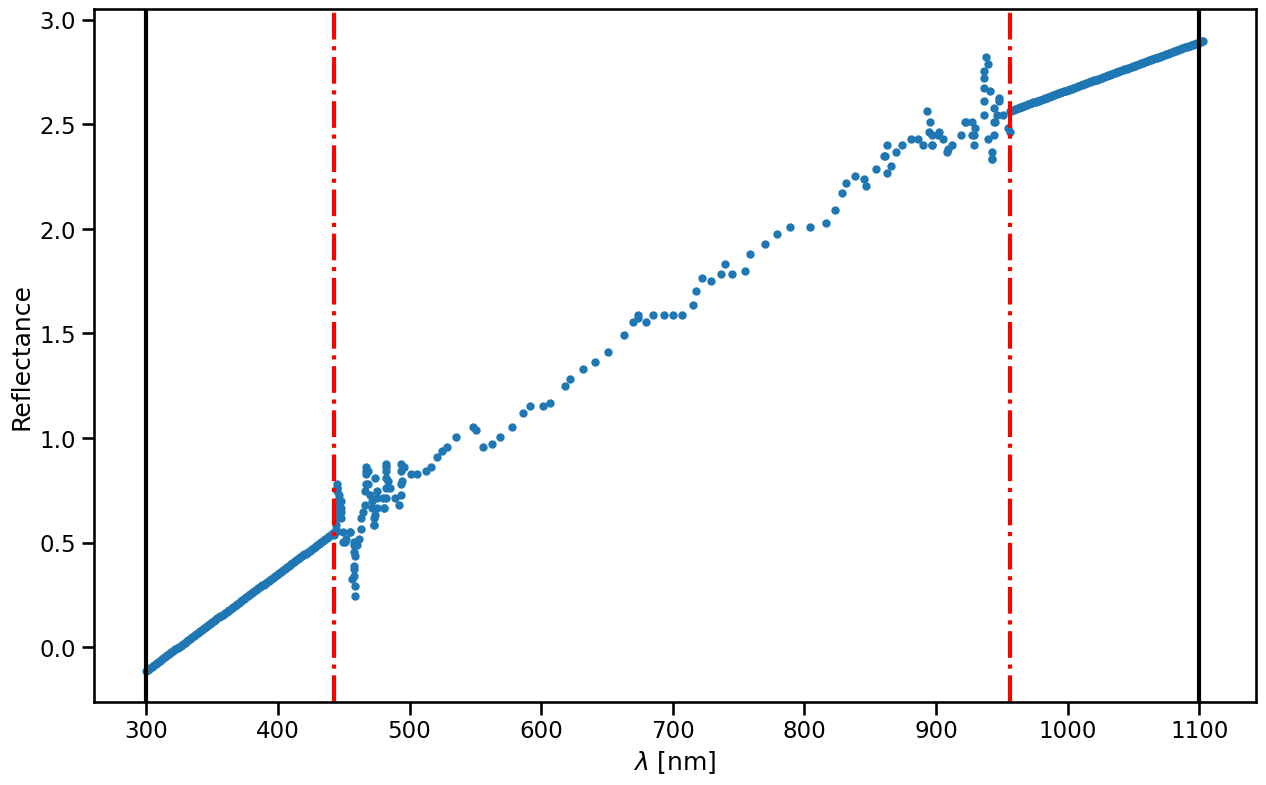

In [158]:
# read in pholus reflectance spectra
phol = pd.read_table('/Users/josephmurtagh/Documents/PhD work/CENTAURSPECTRA/Pholus.dat', names=['wavelen','reflectance'])
phol.wavelen = phol.wavelen * 1000
phol = phol[phol.wavelen < 1000]

# normalise to 550nm by spline fitting and finding reflectance value at 550nm
wavelen_window = np.where((phol.wavelen > 450) & (phol.wavelen < 650))
spl = UnivariateSpline(phol.wavelen.loc[wavelen_window], phol.reflectance.loc[wavelen_window])
spl.set_smoothing_factor(0.01)

xs = np.linspace(450, 650, 201)
idx = np.where((xs > 549.999) & (xs< 550.001))
norm_flux = spl(xs)[np.where((xs > 549.999) & (xs< 550.001))]

phol.reflectance = phol.reflectance / norm_flux

# extrapolate blue end - 1d slinear fits will not work as there are multiple reflectance values at certain wavelengths due to 
# resolution of data. scipy does not support this in order to not break step function interpolation. instead just fit a straight
# line to slope at the end and use gradient to extend down
bluest = phol.wavelen.min()
condition = ((phol.wavelen > bluest) & (phol.wavelen < bluest+100))

popt, pcov = curve_fit(lin, phol.wavelen[condition], phol.reflectance[condition])
wavelen_extend = np.arange(300, bluest+0.5, 1)
reflect_extend = lin(wavelen_extend, popt[0], popt[1])

wavelen_final = np.concatenate((wavelen_extend, phol.wavelen.values))
reflect_final = np.concatenate((reflect_extend, phol.reflectance.values))

# extrapolate red end - same as above
reddest = phol.wavelen.max()
condition = ((phol.wavelen > 850) & (phol.wavelen < 925))

popt, pcov = curve_fit(lin, phol.wavelen[condition], phol.reflectance[condition])
wavelen_extend = np.arange(phol.wavelen.max(), 1103, 1)
reflect_extend = lin(wavelen_extend, popt[0], popt[1])

wavelen_final = np.concatenate((wavelen_final, wavelen_extend))
reflect_final = np.concatenate((reflect_final, reflect_extend))

phol_sed = phot_utils.Sed()
phol_sed.set_sed(wavelen=wavelen_final, flambda=reflect_final)

# plot result, with red dash dot lines for extent of real spectra, and black solid lines for 300-1100nm range
fig = plt.figure(figsize=(15,9))
plt.scatter(wavelen_final, reflect_final, marker='.')
plt.axvline(300, lw=3, color='k')
plt.axvline(1100, lw=3, color='k')
plt.axvline(bluest, lw=3, linestyle='-.', color='r')
plt.axvline(reddest, lw=3, linestyle='-.', color='r')
plt.xlabel(r'$\lambda$ [nm]')
plt.ylabel('Reflectance')

In [137]:
# read in solar spectrum and limit wavelength range
sun = phot_utils.Sed()
sun.read_sed_flambda(os.path.join(get_data_dir(), 'movingObjects', 'kurucz_sun.gz'))

sun_limited = phot_utils.Sed()
idx = np.where((sun.wavelen > 299) & (sun.wavelen < 1105))
sun_limited.set_sed(wavelen=sun.wavelen[idx], flambda=sun.flambda[idx])
sun_limited.resample_sed(wavelen_match=lsst['g'].wavelen)
wavelen_step = np.unique(np.diff(lsst['g'].wavelen)).min()

/Users/josephmurtagh/miniconda3/envs/rubin_sim/lib/python3.11/site-packages/rubin_sim/phot_utils/sed.py:804: UserWarning: There is an area of non-overlap between desired wavelength range  (300.00 to 1150.00)and sed FromArray (299.89 to 1100.95)
  warnings.warn(


nan


/Users/josephmurtagh/miniconda3/envs/rubin_sim/lib/python3.11/site-packages/rubin_sim/phot_utils/sed.py:804: UserWarning: There is an area of non-overlap between desired wavelength range  (300.00 to 1103.00)and sed FromArray (300.00 to 1102.97)
  warnings.warn(
/Users/josephmurtagh/miniconda3/envs/rubin_sim/lib/python3.11/site-packages/rubin_sim/phot_utils/sed.py:804: UserWarning: There is an area of non-overlap between desired wavelength range  (300.00 to 1150.00)and sed FromArray (300.00 to 1103.00)
  warnings.warn(


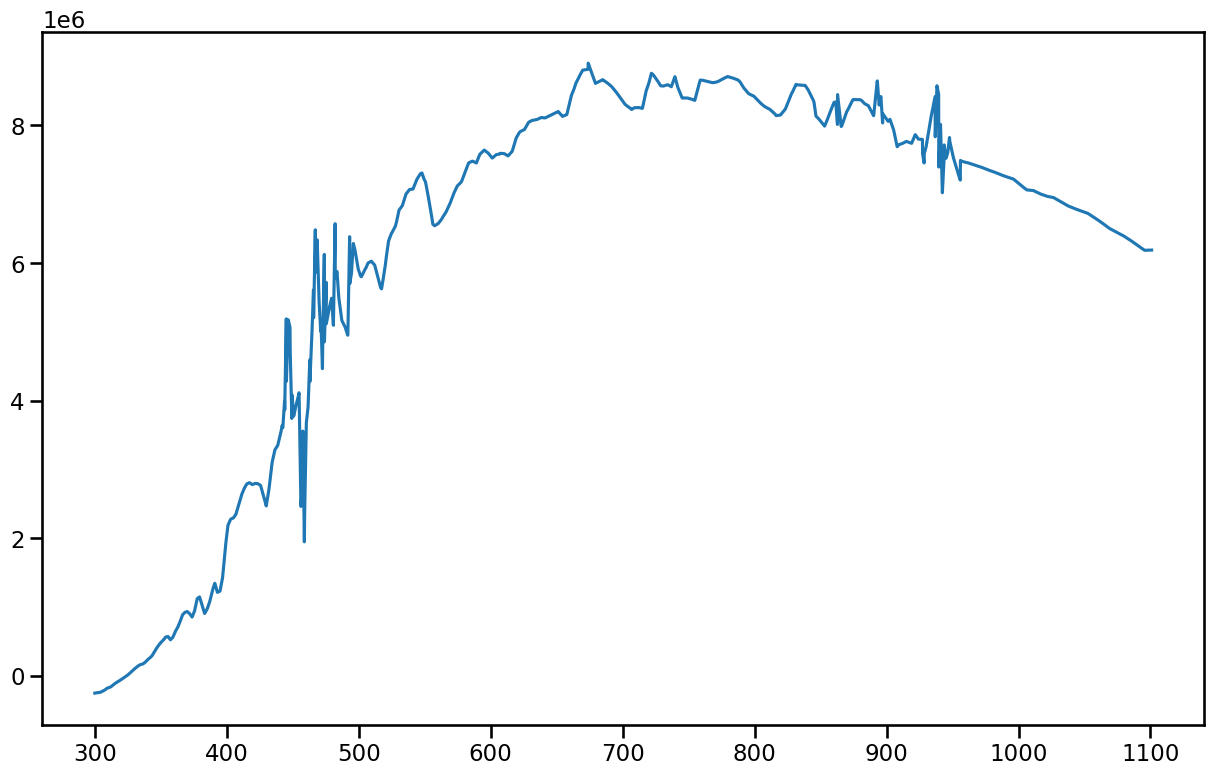

In [161]:
# turn reflectance into sed and plot
phol_obs_sed = phol_sed.multiply_sed(sun_limited, wavelen_step=wavelen_step)

fig = plt.figure(figsize=(15,9))
plt.plot(phol_obs_sed.wavelen, phol_obs_sed.flambda)

# but printing the calculated mag shows nan value
print(phol_obs_sed.calc_mag(lsst['r']))

(0.0, 0.7)

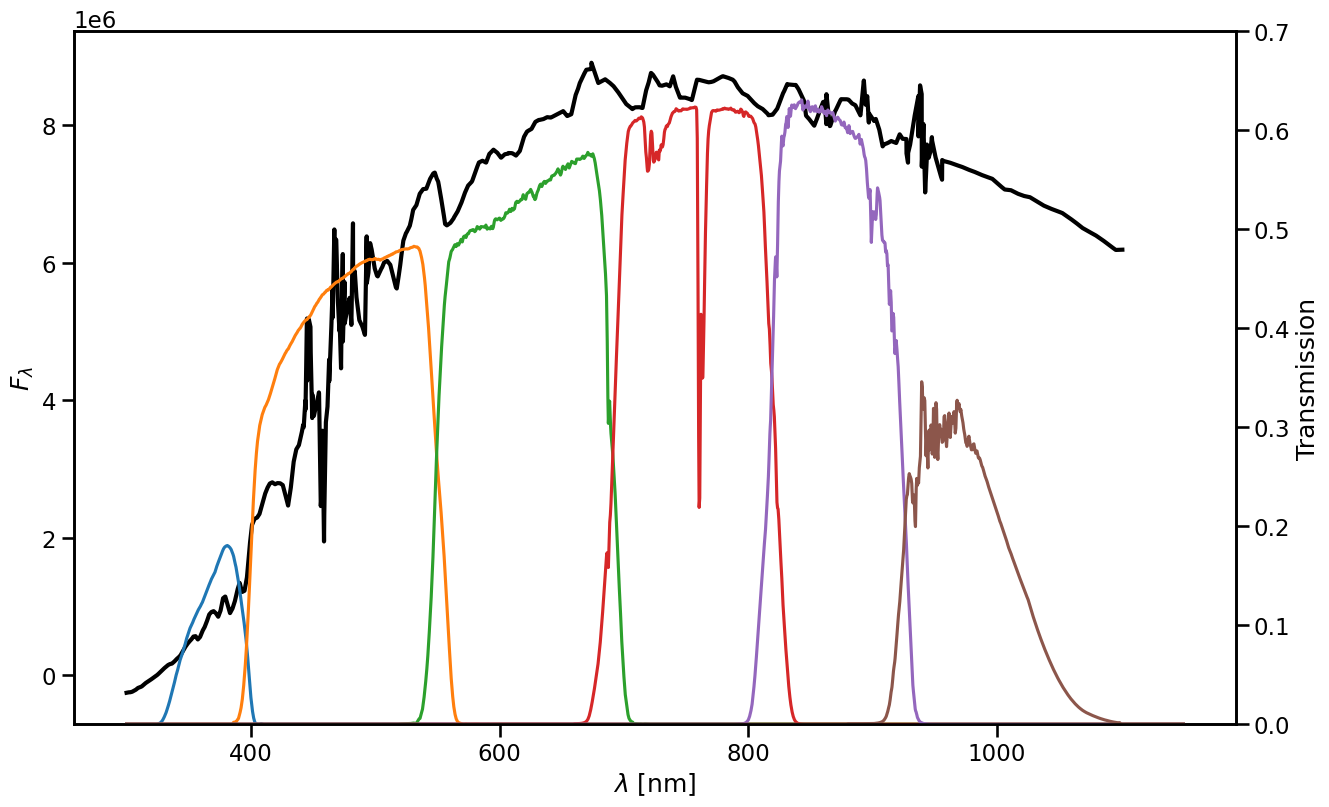

In [160]:
# overplot of above spectrum on the lsst filter range - showing complete overlap of filter bandpasses?
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot(1,1,1)
ax2 = ax1.twinx()

for f in lsst_filterlist:
    ax2.plot(lsst[f].wavelen, lsst[f].sb)

ax1.plot(phol_obs_sed.wavelen, phol_obs_sed.flambda, lw=3, color='k')

ax1.set_xlabel(r'$\lambda$ [nm]')
ax1.set_ylabel(r'$F_\lambda$')
ax2.set_ylabel('Transmission')

ax2.set_ylim(0, 0.7)